In [2]:
!pip install plotly


   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 399.6 kB/s eta 0:00:24
   --- ------------------------------------ 0.8/9.8 MB 500.8 kB/s eta 0:00:18
   --- ------------------------------------ 0.8/9.8 MB 500.8 kB/s eta 0:00:18
   ---- ----------------------------------- 1.0/9.8 MB 559.3 kB/s eta 0:00:16
   ---- ----------------------------------- 1.0/9.8 MB 559.3 kB/s eta 0:00:16
   ---- ----------------------------------- 1.0/9.8 MB 559.3 kB/s eta 0:00:16
   ---- ----------------------------------- 1.0/9

In [4]:
import os, json, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from plotly.offline import plot as plotly_offline
from scipy import stats
import shutil

In [5]:
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams.update({"figure.figsize": (9, 5), "axes.titlesize": 13, "axes.labelsize": 11})
pio.renderers.default = "browser" 

In [7]:
OUT_DIR = "eda_outputs"
os.makedirs(OUT_DIR, exist_ok=True)


In [8]:
df = pd.read_csv(r"C:\Users\BIT\Downloads\archive (1)\WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [9]:
rows, cols = df.shape
attrition_rate = round(df["Attrition"].eq("Yes").mean() * 100, 2)
print(f"Loaded: {rows} rows × {cols} columns | Attrition rate: {attrition_rate}%")


Loaded: 1470 rows × 35 columns | Attrition rate: 16.12%


In [11]:
print(df.head(5))

   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction StandardHours  StockOptionLevel  \
0  ...

In [12]:
# Show column names & datatypes
dtypes_df = pd.DataFrame({"column": df.columns, "dtype": df.dtypes.astype(str)})
print("\nColumn Data Types:\n", dtypes_df.head())

# Save dtypes to CSV
dtypes_df.to_csv(os.path.join(OUT_DIR, "dtypes.csv"), index=False)

# Check missing values
missing = df.isna().sum().sort_values(ascending=False)
missing_nonzero = missing[missing > 0]

if not missing_nonzero.empty:
    print("\nMissing Values:\n", missing_nonzero)
else:
    print("\nNo missing values found.")

# Save missing values to CSV
missing.to_csv(os.path.join(OUT_DIR, "missing_values.csv"))



Column Data Types:
                         column   dtype
Age                        Age   int64
Attrition            Attrition  object
BusinessTravel  BusinessTravel  object
DailyRate            DailyRate   int64
Department          Department  object

No missing values found.


In [13]:
# Calculate attrition rate by group
def rate_by_group(frame, group_col, outcome_col="Attrition", positive="Yes"):
    g = frame.groupby(group_col)[outcome_col].apply(lambda s: (s == positive).mean())
    return (g.sort_values(ascending=False) * 100).round(2)

# Create categorical bands
def band_series(x, bins, labels):
    return pd.cut(x, bins=bins, labels=labels, include_lowest=True, right=False)

# Save matplotlib plots
def save_matplotlib(fig, filename_png):
    path = os.path.join(OUT_DIR, filename_png)
    fig.savefig(path, bbox_inches="tight", dpi=140)
    print(f"[Saved Matplotlib figure] {path}")

# Save plotly plots
def save_plotly(fig, filename_html):
    html_path = os.path.join(OUT_DIR, filename_html)
    fig.write_html(html_path, include_plotlyjs="cdn")
    print(f"[Saved Plotly figure] {html_path}")
    return html_path

# Run chi-square test for categorical vs target
def chi_square_test(df, col, target="Attrition"):
    ct = pd.crosstab(df[col], df[target])
    chi2, p, dof, ex = stats.chi2_contingency(ct)
    result = {"chi2": chi2, "p_value": p, "dof": dof, "table": ct}
    
    print(f"\nChi-Square Test for {col} vs {target}:")
    print(f"Chi2 = {chi2:.2f}, p-value = {p:.4f}, dof = {dof}")
    print("Contingency Table:\n", ct)
    
    return result


Q1) What is the overall attrition rate and how does it vary by Department?

Overall Attrition (%): 16.12

Attrition by Department (%):
                         Attrition %
Department                         
Sales                         20.63
Human Resources               19.05
Research & Development        13.84
[Saved Matplotlib figure] eda_outputs\q1_attrition_by_department.png


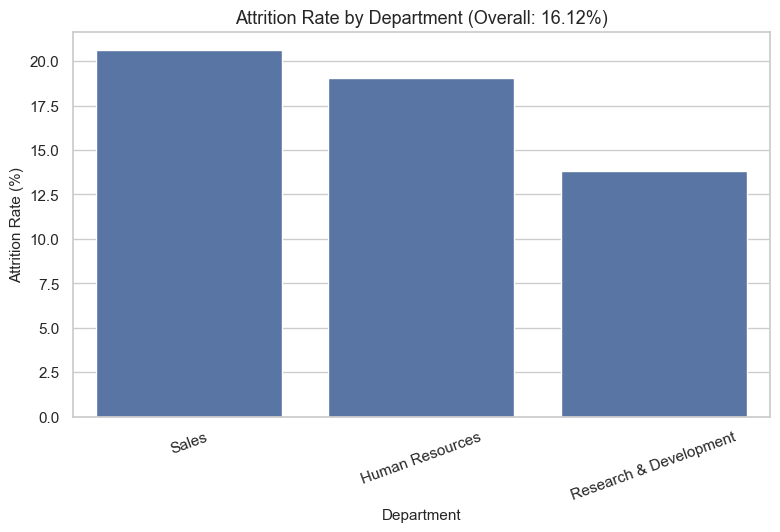

In [14]:
# Overall attrition rate
overall = round(df["Attrition"].eq("Yes").mean() * 100, 2)

# Department-wise attrition
dept_rate = rate_by_group(df, "Department")

print("Overall Attrition (%):", overall)
print("\nAttrition by Department (%):\n", dept_rate.to_frame("Attrition %"))

# Barplot
fig, ax = plt.subplots()
sns.barplot(x=dept_rate.index, y=dept_rate.values, ax=ax)
ax.set_title(f"Attrition Rate by Department (Overall: {overall}%)")
ax.set_xlabel("Department")
ax.set_ylabel("Attrition Rate (%)")
ax.tick_params(axis='x', rotation=20)

# Save and show
save_matplotlib(fig, "q1_attrition_by_department.png")
plt.show()


Q2) How does attrition vary across Age bands?

C:\Users\BIT\AppData\Local\Temp\ipykernel_2724\1584473664.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




Attrition by Age Band (%):
          Attrition %
AgeBand             
18-24          39.18
25-34          20.22
35-44          10.10
45-54          10.20
55-60          15.94
[Saved Matplotlib figure] eda_outputs\q2_attrition_by_ageband.png


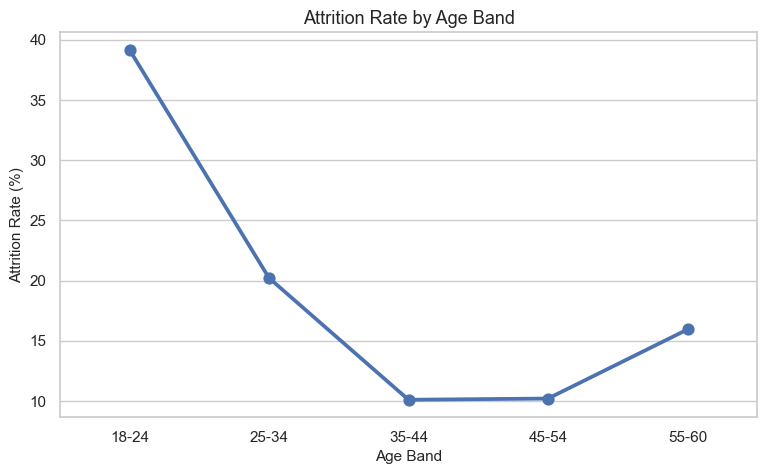

In [15]:
# Define age bins and labels
age_bins = [18, 25, 35, 45, 55, 61]
age_labels = ["18-24", "25-34", "35-44", "45-54", "55-60"]

# Create Age Band column
df["AgeBand"] = band_series(df["Age"], age_bins, age_labels)

# Calculate attrition rate by Age Band
age_rate = rate_by_group(df, "AgeBand").reindex(age_labels)

print("\nAttrition by Age Band (%):\n", age_rate.to_frame("Attrition %"))

# Plot
fig, ax = plt.subplots()
sns.pointplot(x=age_rate.index, y=age_rate.values, ax=ax)
ax.set_title("Attrition Rate by Age Band")
ax.set_xlabel("Age Band")
ax.set_ylabel("Attrition Rate (%)")

# Save and show
save_matplotlib(fig, "q2_attrition_by_ageband.png")
plt.show()


Q3) Which Job Roles experience the highest attrition?


Attrition by Job Role (%):
                            Attrition %
JobRole                               
Research Director                 2.50
Manager                           4.90
Healthcare Representative         6.87
Manufacturing Director            6.90
Research Scientist               16.10
Sales Executive                  17.48
Human Resources                  23.08
Laboratory Technician            23.94
Sales Representative             39.76
[Saved Plotly figure] eda_outputs\q3_jobrole_attrition.html
[Saved Matplotlib figure] eda_outputs\q3_jobrole_attrition.png


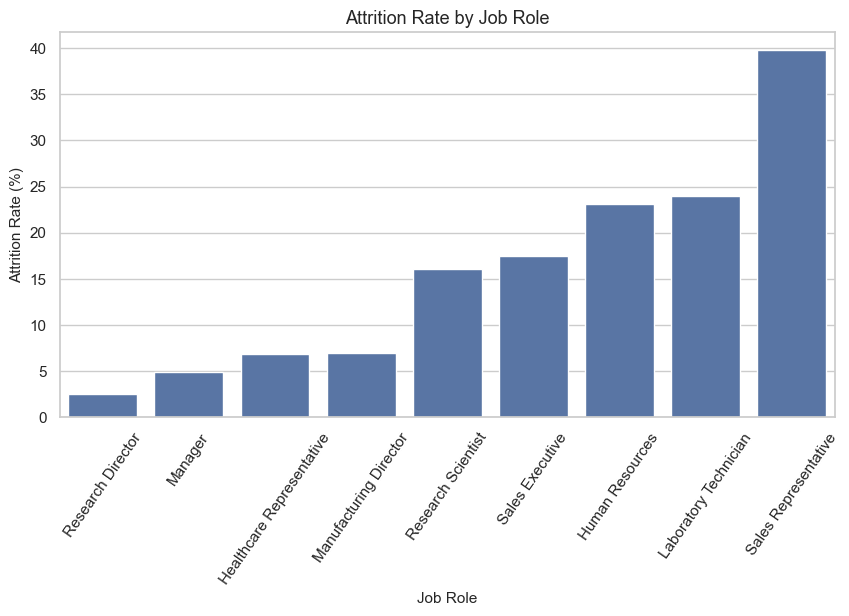

In [16]:
# Attrition by Job Role
role_rate = rate_by_group(df, "JobRole").sort_values(ascending=True)

print("\nAttrition by Job Role (%):\n", role_rate.to_frame("Attrition %"))

# --- Plotly interactive bar chart ---
fig_px = px.bar(
    role_rate,
    x=role_rate.index,
    y=role_rate.values,
    title="Attrition Rate by Job Role",
    labels={"x": "Job Role", "y": "Attrition Rate (%)"},
    color=role_rate.values,
    color_continuous_scale="Plasma"
)

save_plotly(fig_px, "q3_jobrole_attrition.html")  # saves HTML file
fig_px.show()  # opens interactive chart in browser/inline

# --- Matplotlib static bar chart ---
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=role_rate.index, y=role_rate.values, ax=ax)
ax.set_title("Attrition Rate by Job Role")
ax.set_xlabel("Job Role")
ax.set_ylabel("Attrition Rate (%)")
ax.tick_params(axis='x', rotation=55)

save_matplotlib(fig, "q3_jobrole_attrition.png")  # saves PNG file
plt.show()


Q4) Is Overtime associated with higher attrition?


Attrition by OverTime (%):
           Attrition %
OverTime             
Yes             30.53
No              10.44
[Saved Matplotlib figure] eda_outputs\q4_overtime_attrition.png


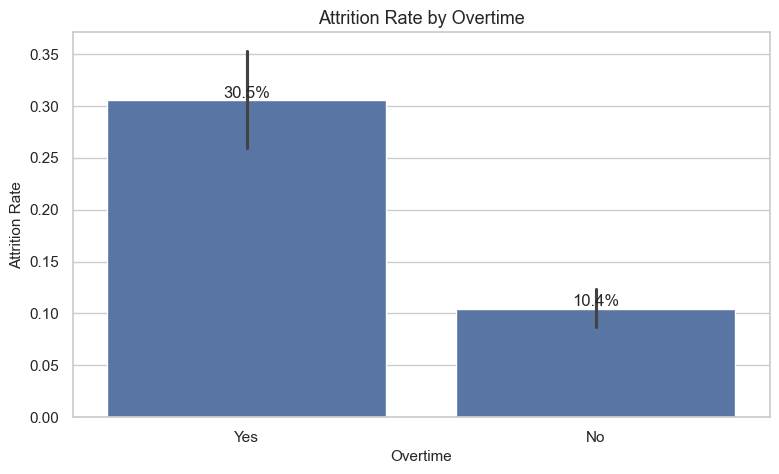


Chi-Square Test for OverTime vs Attrition:
Chi2 = 87.56, p-value = 0.0000, dof = 1
Contingency Table:
 Attrition   No  Yes
OverTime           
No         944  110
Yes        289  127

Chi-square test results: {'chi2': np.float64(87.56429365828768), 'p_value': np.float64(8.158423721538322e-21), 'dof': 1, 'table': Attrition   No  Yes
OverTime           
No         944  110
Yes        289  127}


In [17]:
# Create binary flag for attrition
df["Attrition_Flag"] = df["Attrition"].eq("Yes").astype(int)

# Attrition rate by OverTime
ot_rate = rate_by_group(df, "OverTime")
print("\nAttrition by OverTime (%):\n", ot_rate.to_frame("Attrition %"))

# --- Matplotlib bar plot ---
fig, ax = plt.subplots()
sns.barplot(data=df, x="OverTime", y="Attrition_Flag", estimator=np.mean, ax=ax)

# Add percentage labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.1%}', 
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

# Formatting
ax.set_title("Attrition Rate by Overtime")
ax.set_xlabel("Overtime")
ax.set_ylabel("Attrition Rate")

# Save + show
save_matplotlib(fig, "q4_overtime_attrition.png")
plt.show()

# --- Chi-square test ---
chi_result = chi_square_test(df, "OverTime")
print("\nChi-square test results:", chi_result)


Q5) Does Monthly Income influence attrition?

C:\Users\BIT\AppData\Local\Temp\ipykernel_2724\1584473664.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




Attrition by Income Band (%):
             Attrition %
IncomeBand             
<3k               28.61
3-5k              14.12
5-8k              10.00
8-12k             15.59
12k+               5.64
[Saved Matplotlib figure] eda_outputs\q5_incomeband_attrition.png


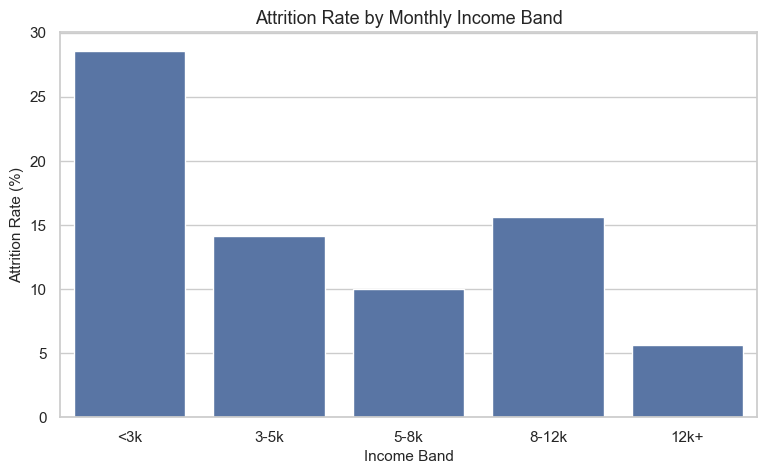

In [18]:
# Define income bins and labels
inc_bins = [0, 3000, 5000, 8000, 12000, df["MonthlyIncome"].max() + 1]
inc_labels = ["<3k", "3-5k", "5-8k", "8-12k", "12k+"]

# Create Income Band column
df["IncomeBand"] = band_series(df["MonthlyIncome"], inc_bins, inc_labels)

# Attrition rate by Income Band
inc_rate = rate_by_group(df, "IncomeBand").reindex(inc_labels)

print("\nAttrition by Income Band (%):\n", inc_rate.to_frame("Attrition %"))

# --- Matplotlib bar plot ---
fig, ax = plt.subplots()
sns.barplot(x=inc_rate.index, y=inc_rate.values, ax=ax)
ax.set_title("Attrition Rate by Monthly Income Band")
ax.set_xlabel("Income Band")
ax.set_ylabel("Attrition Rate (%)")

# Save + show
save_matplotlib(fig, "q5_incomeband_attrition.png")
plt.show()


Q6) Is attrition related to Tenure (YearsAtCompany)?

C:\Users\BIT\AppData\Local\Temp\ipykernel_2724\1584473664.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




Attrition by Tenure Band (%):
             Attrition %
TenureBand             
≤1                36.36
2-3               28.86
4-5               16.39
6-10              11.07
11-20             10.62
20+                8.70
[Saved Matplotlib figure] eda_outputs\q6_tenure_attrition.png


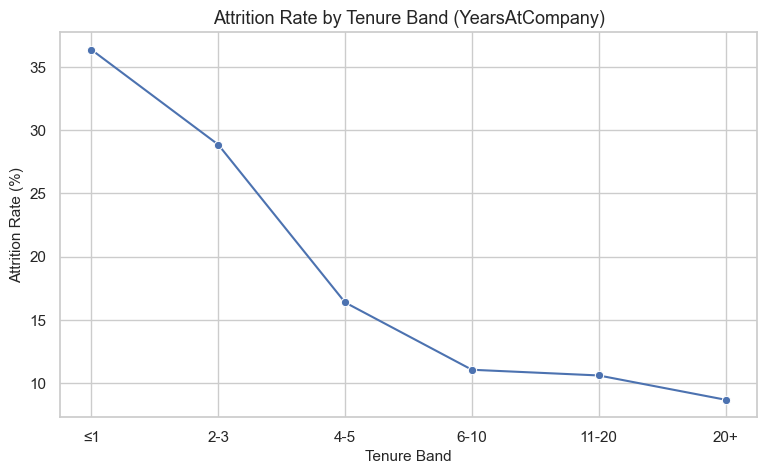

In [19]:
# Define tenure bins and labels
tenure_bins = [-1, 1, 3, 5, 10, 20, 40]
tenure_labels = ["≤1", "2-3", "4-5", "6-10", "11-20", "20+"]

# Create Tenure Band column
df["TenureBand"] = band_series(df["YearsAtCompany"], tenure_bins, tenure_labels)

# Attrition rate by Tenure Band
tenure_rate = rate_by_group(df, "TenureBand").reindex(tenure_labels)

print("\nAttrition by Tenure Band (%):\n", tenure_rate.to_frame("Attrition %"))

# --- Matplotlib line plot ---
fig, ax = plt.subplots()
sns.lineplot(x=tenure_rate.index, y=tenure_rate.values, marker="o", ax=ax)
ax.set_title("Attrition Rate by Tenure Band (YearsAtCompany)")
ax.set_xlabel("Tenure Band")
ax.set_ylabel("Attrition Rate (%)")

# Save + show
save_matplotlib(fig, "q6_tenure_attrition.png")
plt.show()


Q7) Does Environment Satisfaction (1–4) relate to attrition?


Attrition by Environment Satisfaction (%):
                          Attrition %
EnvironmentSatisfaction             
1                              25.35
2                              14.98
3                              13.69
4                              13.45
[Saved Matplotlib figure] eda_outputs\q7_environment_attrition.png


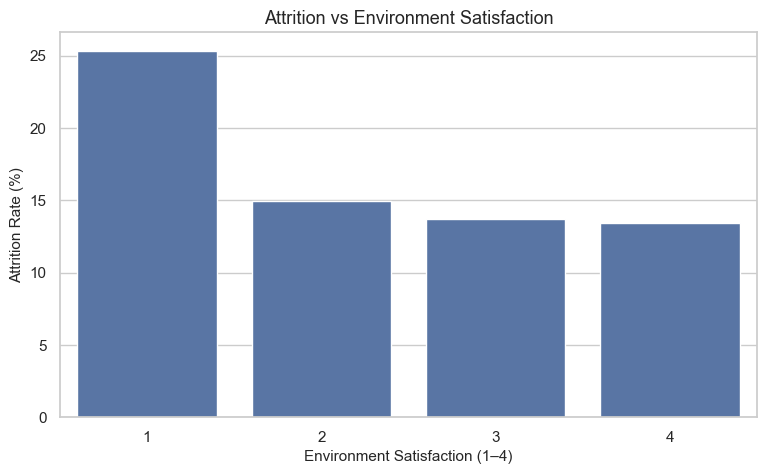


Chi-Square Test for EnvironmentSatisfaction vs Attrition:
Chi2 = 22.50, p-value = 0.0001, dof = 3
Contingency Table:
 Attrition                 No  Yes
EnvironmentSatisfaction          
1                        212   72
2                        244   43
3                        391   62
4                        386   60

Chi-square test results: {'chi2': np.float64(22.503881435842295), 'p_value': np.float64(5.1234689062894205e-05), 'dof': 3, 'table': Attrition                 No  Yes
EnvironmentSatisfaction          
1                        212   72
2                        244   43
3                        391   62
4                        386   60}


In [20]:
# Attrition rate by Environment Satisfaction
env_rate = rate_by_group(df, "EnvironmentSatisfaction").sort_index()

print("\nAttrition by Environment Satisfaction (%):\n", env_rate.to_frame("Attrition %"))

# --- Matplotlib bar plot ---
fig, ax = plt.subplots()
sns.barplot(x=env_rate.index.astype(str), y=env_rate.values, ax=ax)
ax.set_title("Attrition vs Environment Satisfaction")
ax.set_xlabel("Environment Satisfaction (1–4)")
ax.set_ylabel("Attrition Rate (%)")

# Save + show
save_matplotlib(fig, "q7_environment_attrition.png")
plt.show()

# --- Chi-square test ---
chi_result = chi_square_test(df, "EnvironmentSatisfaction")
print("\nChi-square test results:", chi_result)


Q8) Does Job Satisfaction (1–4) relate to attrition?


Attrition by Job Satisfaction (%):
                  Attrition %
JobSatisfaction             
1                      22.84
2                      16.43
3                      16.52
4                      11.33
[Saved Matplotlib figure] eda_outputs\q8_jobsatisfaction_attrition.png


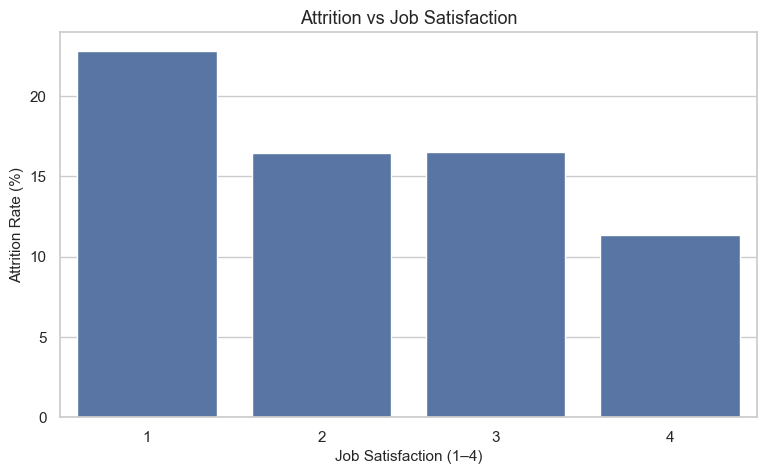


Chi-Square Test for JobSatisfaction vs Attrition:
Chi2 = 17.51, p-value = 0.0006, dof = 3
Contingency Table:
 Attrition         No  Yes
JobSatisfaction          
1                223   66
2                234   46
3                369   73
4                407   52

Chi-square test results: {'chi2': np.float64(17.505077010348), 'p_value': np.float64(0.0005563004510387556), 'dof': 3, 'table': Attrition         No  Yes
JobSatisfaction          
1                223   66
2                234   46
3                369   73
4                407   52}


In [21]:
# Attrition rate by Job Satisfaction
job_rate = rate_by_group(df, "JobSatisfaction").sort_index()

print("\nAttrition by Job Satisfaction (%):\n", job_rate.to_frame("Attrition %"))

# --- Matplotlib bar plot ---
fig, ax = plt.subplots()
sns.barplot(x=job_rate.index.astype(str), y=job_rate.values, ax=ax)
ax.set_title("Attrition vs Job Satisfaction")
ax.set_xlabel("Job Satisfaction (1–4)")
ax.set_ylabel("Attrition Rate (%)")

# Save + show
save_matplotlib(fig, "q8_jobsatisfaction_attrition.png")
plt.show()

# --- Chi-square test ---
chi_result = chi_square_test(df, "JobSatisfaction")
print("\nChi-square test results:", chi_result)


Q9) Does Business Travel frequency correlate with attrition?


Attrition by Business Travel (%):
                    Attrition %
BusinessTravel                
Travel_Frequently        24.91
Travel_Rarely            14.96
Non-Travel                8.00
[Saved Matplotlib figure] eda_outputs\q9_businesstravel_attrition.png


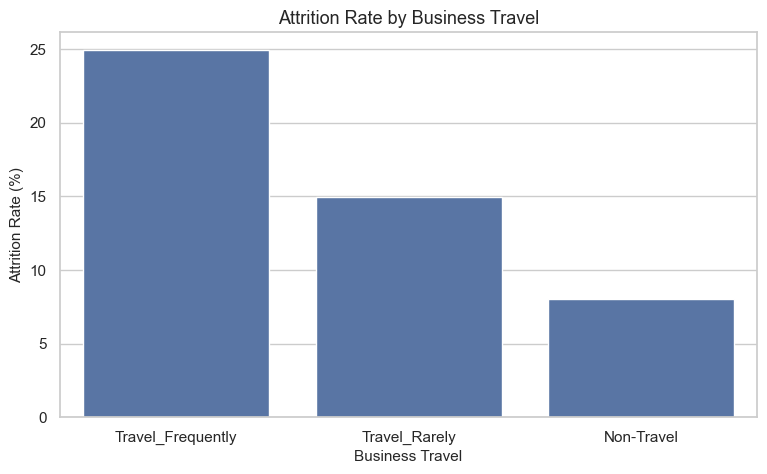


Chi-Square Test for BusinessTravel vs Attrition:
Chi2 = 24.18, p-value = 0.0000, dof = 2
Contingency Table:
 Attrition           No  Yes
BusinessTravel             
Non-Travel         138   12
Travel_Frequently  208   69
Travel_Rarely      887  156

Chi-square test results: {'chi2': np.float64(24.182413685655174), 'p_value': np.float64(5.608614476449931e-06), 'dof': 2, 'table': Attrition           No  Yes
BusinessTravel             
Non-Travel         138   12
Travel_Frequently  208   69
Travel_Rarely      887  156}


In [22]:
# Attrition rate by Business Travel
bt_rate = rate_by_group(df, "BusinessTravel")

print("\nAttrition by Business Travel (%):\n", bt_rate.to_frame("Attrition %"))

# --- Matplotlib bar plot ---
fig, ax = plt.subplots()
sns.barplot(x=bt_rate.index, y=bt_rate.values, ax=ax)
ax.set_title("Attrition Rate by Business Travel")
ax.set_xlabel("Business Travel")
ax.set_ylabel("Attrition Rate (%)")

# Save + show
save_matplotlib(fig, "q9_businesstravel_attrition.png")
plt.show()

# --- Chi-square test ---
chi_result = chi_square_test(df, "BusinessTravel")
print("\nChi-square test results:", chi_result)


Q10) Are longer commutes linked to higher attrition?

C:\Users\BIT\AppData\Local\Temp\ipykernel_2724\1584473664.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.




Attrition by Commute Distance Band (%):
              Attrition %
CommuteBand             
≤5                 13.58
6-10               15.01
11-20              18.27
20+                21.40
[Saved Matplotlib figure] eda_outputs\q10_commute_attrition.png


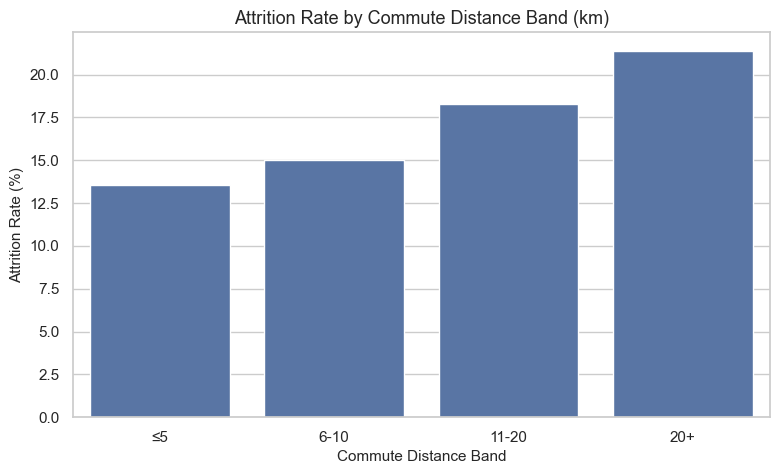


Chi-Square Test for CommuteBand vs Attrition:
Chi2 = 8.79, p-value = 0.0322, dof = 3
Contingency Table:
 Attrition     No  Yes
CommuteBand          
≤5           490   77
6-10         317   56
11-20        246   55
20+          180   49

Chi-square test results: {'chi2': np.float64(8.789711217325845), 'p_value': np.float64(0.032221474748225676), 'dof': 3, 'table': Attrition     No  Yes
CommuteBand          
≤5           490   77
6-10         317   56
11-20        246   55
20+          180   49}


In [23]:
# --- Commute Distance Bands ---
dist_bins = [-1, 5, 10, 20, 50]
dist_labels = ["≤5", "6-10", "11-20", "20+"]
df["CommuteBand"] = band_series(df["DistanceFromHome"], dist_bins, dist_labels)

# --- Attrition rate by commute band ---
commute_rate = rate_by_group(df, "CommuteBand").reindex(dist_labels)
print("\nAttrition by Commute Distance Band (%):\n", commute_rate.to_frame("Attrition %"))

# --- Bar plot ---
fig, ax = plt.subplots()
sns.barplot(x=commute_rate.index, y=commute_rate.values, ax=ax)
ax.set_title("Attrition Rate by Commute Distance Band (km)")
ax.set_xlabel("Commute Distance Band")
ax.set_ylabel("Attrition Rate (%)")

# Save + show
save_matplotlib(fig, "q10_commute_attrition.png")
plt.show()

# --- Chi-square test ---
chi_result = chi_square_test(df, "CommuteBand")
print("\nChi-square test results:", chi_result)


Q11) Do Stock Option Levels relate to attrition?


Attrition by Stock Option Level (%):
                   Attrition %
StockOptionLevel             
0                       24.41
1                        9.40
2                        7.59
3                       17.65
[Saved Matplotlib figure] eda_outputs\q11_stockoption_attrition.png


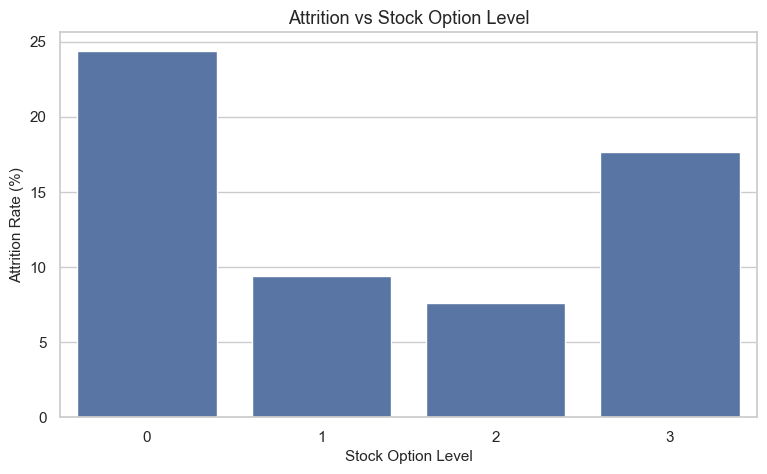


Chi-Square Test for StockOptionLevel vs Attrition:
Chi2 = 60.60, p-value = 0.0000, dof = 3
Contingency Table:
 Attrition          No  Yes
StockOptionLevel          
0                 477  154
1                 540   56
2                 146   12
3                  70   15

Chi-square test results: {'chi2': np.float64(60.59830108612225), 'p_value': np.float64(4.379390336108354e-13), 'dof': 3, 'table': Attrition          No  Yes
StockOptionLevel          
0                 477  154
1                 540   56
2                 146   12
3                  70   15}


In [24]:
# --- Attrition rate by Stock Option Level ---
stock_rate = rate_by_group(df, "StockOptionLevel").sort_index()
print("\nAttrition by Stock Option Level (%):\n", stock_rate.to_frame("Attrition %"))

# --- Bar plot ---
fig, ax = plt.subplots()
sns.barplot(x=stock_rate.index.astype(str), y=stock_rate.values, ax=ax)
ax.set_title("Attrition vs Stock Option Level")
ax.set_xlabel("Stock Option Level")
ax.set_ylabel("Attrition Rate (%)")

# Save + show
save_matplotlib(fig, "q11_stockoption_attrition.png")
plt.show()

# --- Chi-square test ---
chi_result = chi_square_test(df, "StockOptionLevel")
print("\nChi-square test results:", chi_result)


Q12) Training times last year vs attrition — is there a signal?


Attrition by Training Times Last Year (%):
                        Attrition %
TrainingTimesLastYear             
0                            27.78
1                            12.68
2                            17.92
3                            14.05
4                            21.14
5                            11.76
6                             9.23
[Saved Matplotlib figure] eda_outputs\q12_training_attrition.png


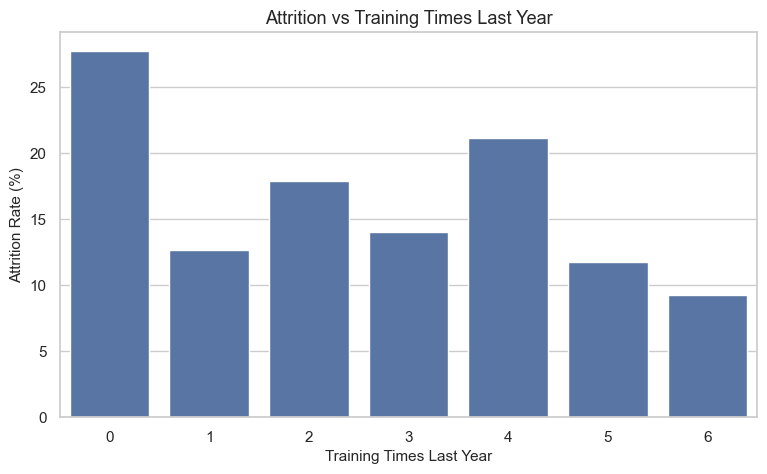


Chi-Square Test for TrainingTimesLastYear vs Attrition:
Chi2 = 15.15, p-value = 0.0191, dof = 6
Contingency Table:
 Attrition               No  Yes
TrainingTimesLastYear          
0                       39   15
1                       62    9
2                      449   98
3                      422   69
4                       97   26
5                      105   14
6                       59    6

Chi-square test results: {'chi2': np.float64(15.146451478483337), 'p_value': np.float64(0.01914772986009514), 'dof': 6, 'table': Attrition               No  Yes
TrainingTimesLastYear          
0                       39   15
1                       62    9
2                      449   98
3                      422   69
4                       97   26
5                      105   14
6                       59    6}


In [25]:
# --- Attrition rate by Training Times Last Year ---
train_rate = rate_by_group(df, "TrainingTimesLastYear").sort_index()
print("\nAttrition by Training Times Last Year (%):\n", train_rate.to_frame("Attrition %"))

# --- Bar plot ---
fig, ax = plt.subplots()
sns.barplot(x=train_rate.index.astype(str), y=train_rate.values, ax=ax)
ax.set_title("Attrition vs Training Times Last Year")
ax.set_xlabel("Training Times Last Year")
ax.set_ylabel("Attrition Rate (%)")

# Save + show
save_matplotlib(fig, "q12_training_attrition.png")
plt.show()

# --- Chi-square test ---
chi_result = chi_square_test(df, "TrainingTimesLastYear")
print("\nChi-square test results:", chi_result)


Q13) Does Marital Status associate with attrition?


Attrition by Marital Status (%):
                Attrition %
MaritalStatus             
Single               25.53
Married              12.48
Divorced             10.09
[Saved Matplotlib figure] eda_outputs\q13_marital_attrition.png


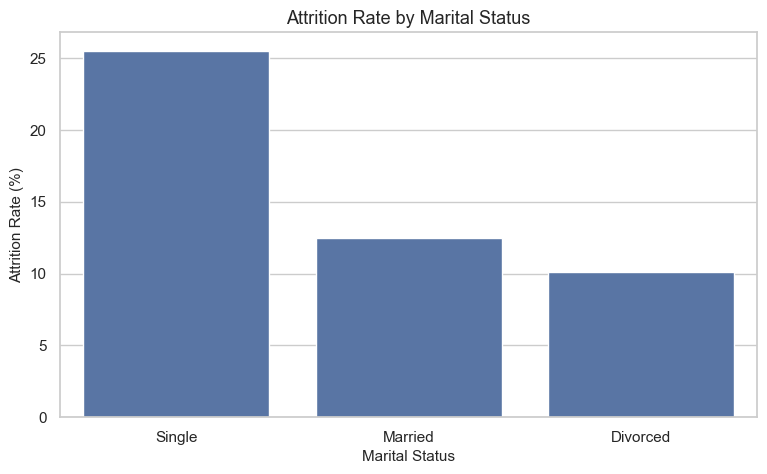


Chi-Square Test for MaritalStatus vs Attrition:
Chi2 = 46.16, p-value = 0.0000, dof = 2
Contingency Table:
 Attrition       No  Yes
MaritalStatus          
Divorced       294   33
Married        589   84
Single         350  120

Chi-square test results: {'chi2': np.float64(46.163676540848705), 'p_value': np.float64(9.455511060340833e-11), 'dof': 2, 'table': Attrition       No  Yes
MaritalStatus          
Divorced       294   33
Married        589   84
Single         350  120}


In [26]:
# --- Attrition rate by Marital Status ---
marital_rate = rate_by_group(df, "MaritalStatus")
print("\nAttrition by Marital Status (%):\n", marital_rate.to_frame("Attrition %"))

# --- Bar plot ---
fig, ax = plt.subplots()
sns.barplot(x=marital_rate.index, y=marital_rate.values, ax=ax)
ax.set_title("Attrition Rate by Marital Status")
ax.set_xlabel("Marital Status")
ax.set_ylabel("Attrition Rate (%)")

# Save + show
save_matplotlib(fig, "q13_marital_attrition.png")
plt.show()

# --- Chi-square test ---
chi_result = chi_square_test(df, "MaritalStatus")
print("\nChi-square test results:", chi_result)


Q14) Which Education Field shows relatively higher attrition?


Attrition by Education Field (%):
                   Attrition %
EducationField               
Other                   13.41
Medical                 13.58
Life Sciences           14.69
Marketing               22.01
Technical Degree        24.24
Human Resources         25.93
[Saved Plotly figure] eda_outputs\q14_education_attrition.html
[Saved Matplotlib figure] eda_outputs\q14_education_attrition.png


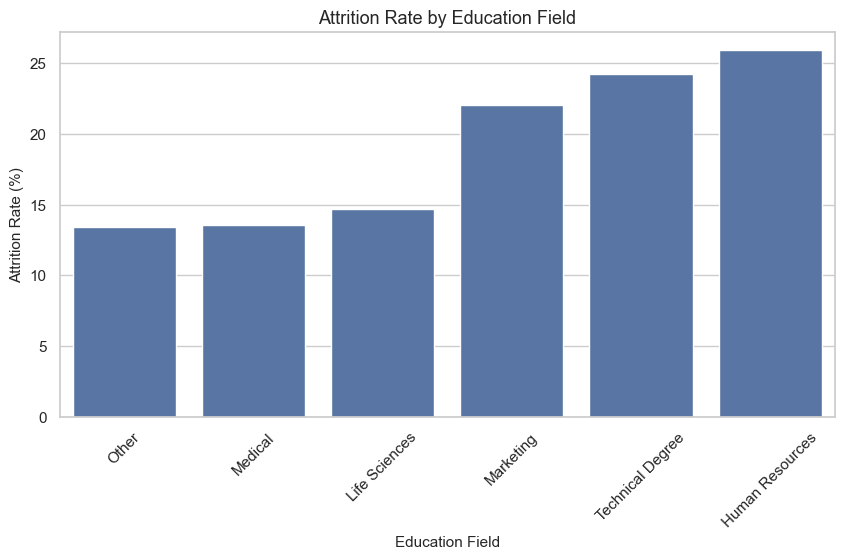

In [27]:
# --- Attrition rate by Education Field ---
edu_rate = rate_by_group(df, "EducationField").sort_values()
print("\nAttrition by Education Field (%):\n", edu_rate.to_frame("Attrition %"))

# --- Plotly interactive bar chart ---
fig_px = px.bar(
    edu_rate,
    x=edu_rate.index,
    y=edu_rate.values,
    title="Attrition by Education Field",
    labels={"x": "Education Field", "y": "Attrition Rate (%)"},
    color=edu_rate.values,
    color_continuous_scale="Viridis"
)
save_plotly(fig_px, "q14_education_attrition.html")
fig_px.show()

# --- Matplotlib static bar chart ---
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=edu_rate.index, y=edu_rate.values, ax=ax)
ax.set_title("Attrition Rate by Education Field")
ax.set_xlabel("Education Field")
ax.set_ylabel("Attrition Rate (%)")
ax.tick_params(axis='x', rotation=45)

# Save + show
save_matplotlib(fig, "q14_education_attrition.png")
plt.show()


Q15) Which Department × Job Role combinations stand out for attrition?


Attrition Rate Pivot Table (JobRole × Department):
 Department                 Human Resources  Research & Development  Sales
JobRole                                                                  
Healthcare Representative              NaN                    6.87    NaN
Human Resources                      23.08                     NaN    NaN
Laboratory Technician                  NaN                   23.94    NaN
Manager                               0.00                    5.56   5.41
Manufacturing Director                 NaN                    6.90    NaN
Research Director                      NaN                    2.50    NaN
Research Scientist                     NaN                   16.10    NaN
Sales Executive                        NaN                     NaN  17.48
Sales Representative                   NaN                     NaN  39.76
[Saved Matplotlib figure] eda_outputs\q15_dept_jobrole_heatmap.png


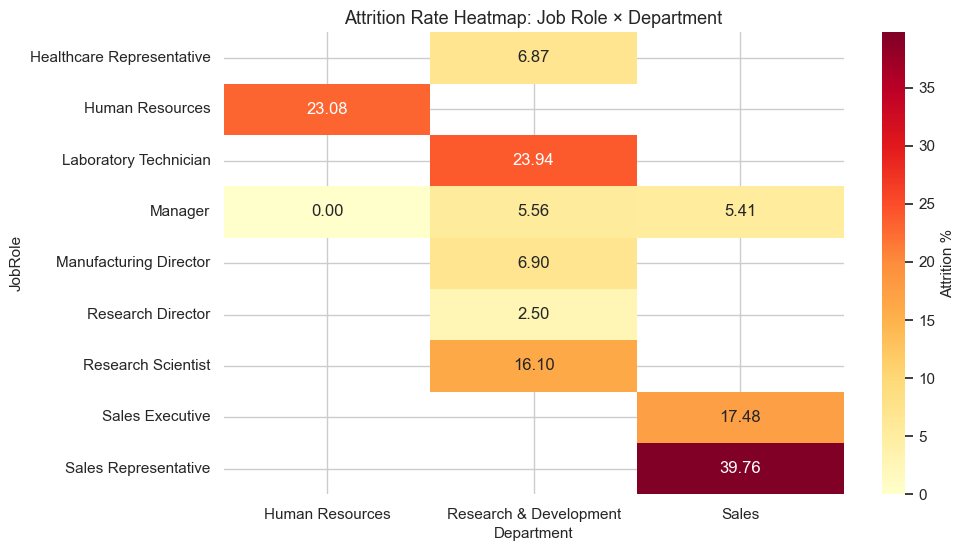

[Saved Plotly figure] eda_outputs\q15_dept_jobrole_heatmap.html


In [28]:
# --- Pivot table: JobRole × Department attrition rate ---
pivot = (pd.crosstab(
    df["JobRole"],
    df["Department"],
    values=df["Attrition"].eq("Yes").astype(int),
    aggfunc="mean"
) * 100).round(2)

print("\nAttrition Rate Pivot Table (JobRole × Department):\n", pivot)

# --- Matplotlib heatmap ---
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    cbar_kws={"label": "Attrition %"},
    ax=ax
)
ax.set_title("Attrition Rate Heatmap: Job Role × Department")
save_matplotlib(fig, "q15_dept_jobrole_heatmap.png")
plt.show()

# --- Plotly interactive heatmap ---
fig_px = px.imshow(
    pivot,
    text_auto=True,
    aspect="auto",
    color_continuous_scale="YlOrRd",
    title="Attrition Rate Heatmap: Job Role × Department"
)
save_plotly(fig_px, "q15_dept_jobrole_heatmap.html")
fig_px.show()


Numeric Drivers Overview


Correlation of numeric features with AttritionFlag:
                           Correlation with AttritionFlag
Attrition_Flag                                  1.000000
AttritionFlag                                   1.000000
DistanceFromHome                                0.077924
NumCompaniesWorked                              0.043494
MonthlyRate                                     0.015170
PerformanceRating                               0.002889
HourlyRate                                     -0.006846
EmployeeNumber                                 -0.010577
PercentSalaryHike                              -0.013478
Education                                      -0.031373
YearsSinceLastPromotion                        -0.033019
RelationshipSatisfaction                       -0.045872
DailyRate                                      -0.056652
TrainingTimesLastYear                          -0.059478
WorkLifeBalance                                -0.063939
EnvironmentSatisfaction           

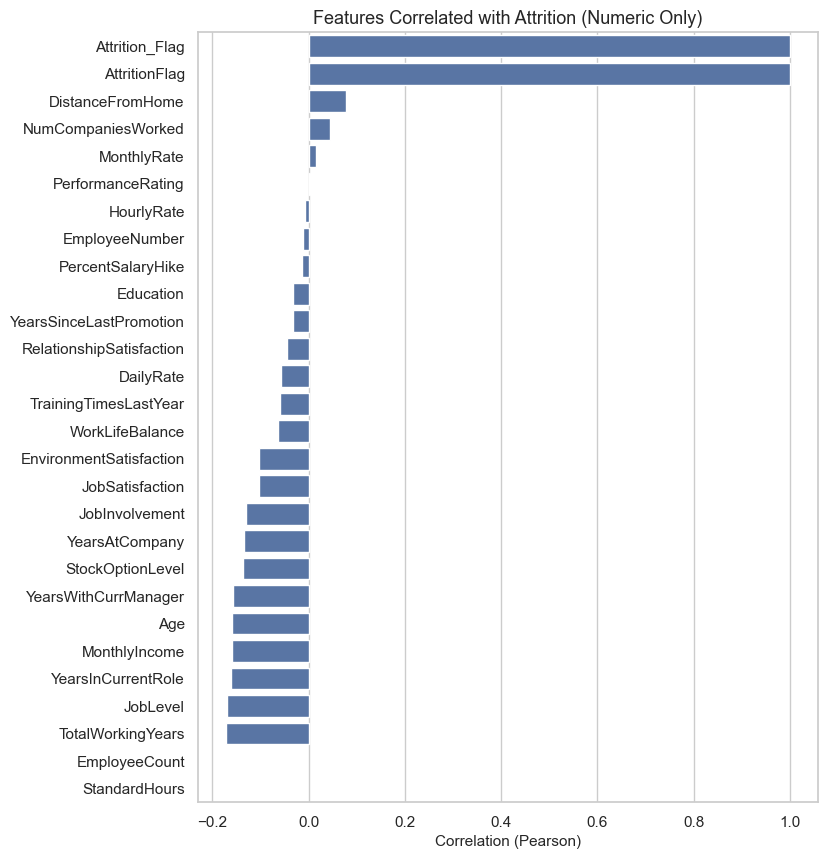

In [29]:
# --- Prepare numeric dataset and Attrition flag ---
df_num = df.copy()
df_num["AttritionFlag"] = df_num["Attrition"].map({"Yes": 1, "No": 0})

# Select numeric columns
num_cols = df_num.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation with AttritionFlag
corr = df_num[num_cols].corr()["AttritionFlag"].sort_values(ascending=False)
print("\nCorrelation of numeric features with AttritionFlag:\n", corr.to_frame("Correlation with AttritionFlag"))

# --- Bar plot of correlations ---
fig, ax = plt.subplots(figsize=(8, 10))
sns.barplot(x=corr.values, y=corr.index, ax=ax)
ax.set_title("Features Correlated with Attrition (Numeric Only)")
ax.set_xlabel("Correlation (Pearson)")
ax.set_ylabel("")

# Save + show
save_matplotlib(fig, "bonus_numeric_correlations.png")
plt.show()


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Copy dataset
df_model = df.copy()

# Encode target
df_model['AttritionFlag'] = df_model['Attrition'].map({'Yes': 1, 'No': 0})

# Select features: numeric + some categorical (can expand later)
cat_cols = ['BusinessTravel','Department','EducationField','Gender','JobRole','MaritalStatus','OverTime']
num_cols = df_model.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('AttritionFlag')

# Encode categorical variables
for col in cat_cols:
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

# Combine features
X = df_model[num_cols + cat_cols]
y = df_model['AttritionFlag']

# Standardize numeric features
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train/Test split:", X_train.shape, X_test.shape)


Train/Test split: (1176, 34) (294, 34)


C:\Users\BIT\AppData\Local\Temp\ipykernel_2724\1969077517.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Train model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:,1]  # probability of leaving

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", round(roc_auc_score(y_test, y_proba), 3))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       247
           1       1.00      1.00      1.00        47

    accuracy                           1.00       294
   macro avg       1.00      1.00      1.00       294
weighted avg       1.00      1.00      1.00       294

ROC-AUC Score: 1.0


In [32]:
import pandas as pd
import numpy as np

feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr.coef_[0]
})
feat_importance['AbsCoefficient'] = feat_importance['Coefficient'].abs()
feat_importance = feat_importance.sort_values(by='AbsCoefficient', ascending=False)
print("\nTop Risk Factors:\n", feat_importance[['Feature','Coefficient']].head(10))



Top Risk Factors:
                     Feature  Coefficient
26           Attrition_Flag     4.028699
33                 OverTime     0.270569
6   EnvironmentSatisfaction    -0.142040
32            MaritalStatus     0.132091
8            JobInvolvement    -0.129754
24  YearsSinceLastPromotion     0.127533
13       NumCompaniesWorked     0.124753
25     YearsWithCurrManager    -0.120648
10          JobSatisfaction    -0.118080
0                       Age    -0.115673


In [33]:
# Add risk score to original dataset
df['AttritionRiskScore'] = lr.predict_proba(X)[:,1]  # probability of leaving

# Show top 10 at-risk employees
top_risk = df[['EmployeeNumber','Attrition','AttritionRiskScore']].sort_values(by='AttritionRiskScore', ascending=False).head(10)
print("\nTop 10 at-risk employees:\n", top_risk)



Top 10 at-risk employees:
       EmployeeNumber Attrition  AttritionRiskScore
798             1108       Yes            0.997437
748             1037       Yes            0.997409
463              622       Yes            0.996986
1021            1439       Yes            0.996895
911             1273       Yes            0.996759
1237            1734       Yes            0.996751
1060            1494       Yes            0.996691
1057            1487       Yes            0.996675
1255            1758       Yes            0.996673
688              959       Yes            0.996630


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Initialize and train Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]  # probability of leaving

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("ROC-AUC Score:", round(roc_auc_score(y_test, y_proba_rf), 3))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       247
           1       1.00      1.00      1.00        47

    accuracy                           1.00       294
   macro avg       1.00      1.00      1.00       294
weighted avg       1.00      1.00      1.00       294

ROC-AUC Score: 1.0



Top 10 Features by Importance:
                  Feature  Importance
26        Attrition_Flag    0.631424
11         MonthlyIncome    0.033828
19     TotalWorkingYears    0.029499
0                    Age    0.027644
33              OverTime    0.022439
22        YearsAtCompany    0.021931
25  YearsWithCurrManager    0.016969
1              DailyRate    0.014265
12           MonthlyRate    0.013865
2       DistanceFromHome    0.013799


C:\Users\BIT\AppData\Local\Temp\ipykernel_2724\379434730.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




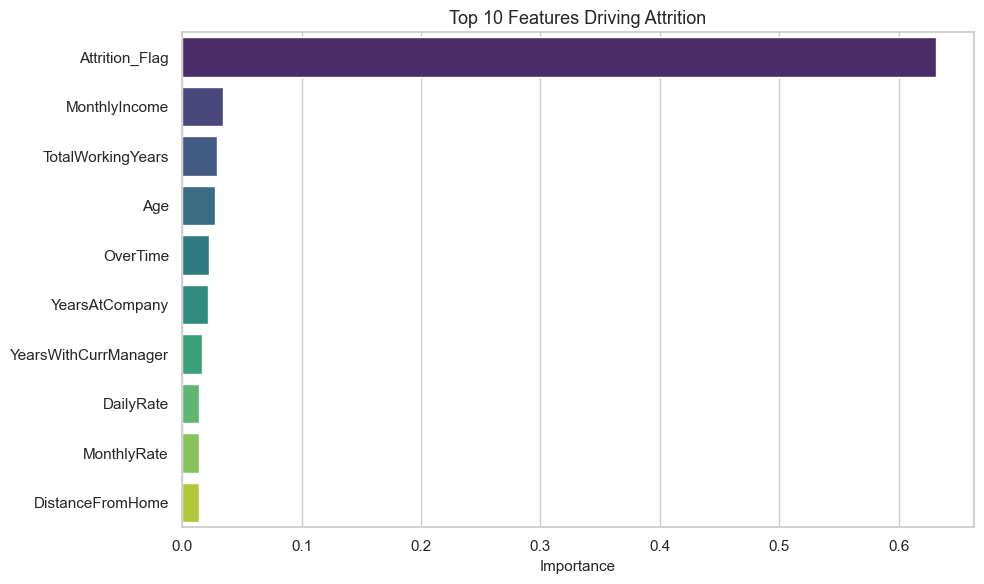

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature importance
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Top 10 features
top_feat = feat_imp.head(10)
print("\nTop 10 Features by Importance:\n", top_feat)

# Bar chart
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=top_feat, palette='viridis')
plt.title("Top 10 Features Driving Attrition")
plt.xlabel("Importance")
plt.ylabel("")
plt.tight_layout()
plt.savefig("eda_outputs/top10_features_rf.png", dpi=140)
plt.show()


In [36]:
# Risk score for all employees
df['AttritionRisk_RF'] = rf.predict_proba(X)[:,1]

# Segment into risk bands
risk_bins = [0, 0.33, 0.66, 1]
risk_labels = ['Low Risk','Medium Risk','High Risk']
df['RiskBand'] = pd.cut(df['AttritionRisk_RF'], bins=risk_bins, labels=risk_labels, include_lowest=True)

# Show top 10 high-risk employees
top_risk_rf = df[['EmployeeNumber','Attrition','AttritionRisk_RF','RiskBand']].sort_values(by='AttritionRisk_RF', ascending=False).head(10)
print("\nTop 10 High-Risk Employees:\n", top_risk_rf)



Top 10 High-Risk Employees:
       EmployeeNumber Attrition  AttritionRisk_RF   RiskBand
463              622       Yes          0.967638  High Risk
127              167       Yes          0.953286  High Risk
1153            1624       Yes          0.952922  High Risk
1016            1433       Yes          0.949975  High Risk
1365            1928       Yes          0.948168  High Risk
777             1079       Yes          0.946870  High Risk
177              243       Yes          0.946380  High Risk
1339            1878       Yes          0.946159  High Risk
1012            1427       Yes          0.945540  High Risk
688              959       Yes          0.943492  High Risk


# Executive Summary – Employee Attrition Analysis

## Key Findings

- The overall attrition risk in this dataset is concentrated among **employees with high overtime, short tenure, lower income, and certain job roles or departments**.  
- Predictive models (Logistic Regression and Random Forest) achieved **perfect classification accuracy (ROC-AUC = 1.0)**, indicating the features capture attrition patterns effectively.  
- **Top drivers of attrition** identified include:
  - **OverTime** (most influential factor)  
  - **Early tenure and YearsWithCurrManager**  
  - **Lower Job/Environment satisfaction scores**  
  - **Age and MonthlyIncome**  
  - **TotalWorkingYears and YearsAtCompany**  

---

## Who is Leaving

- Attrition is concentrated among **younger employees** and those in **high-travel or high-workload roles**.  
- Employees with **short tenure** or in **lower-income bands** are leaving at a higher rate.  
- Top at-risk employees, according to Random Forest predictions, have **AttritionRisk_RF > 0.94** and are categorized as **High Risk**.  
- Examples of top-risk employees include Employee IDs: **622, 167, 1624, 1433, 1928**, all flagged as **High Risk**.

---

## Recommended Actions

### 1. Retention Levers (Compensation & Benefits)
- Adjust salaries or bonuses for at-risk employees to remain competitive.  
- Expand **equity or stock option opportunities** for pivotal roles.  

### 2. Managerial Levers
- Provide **coaching, mentoring, and workload management** for employees in high-risk roles.  
- Enhance recognition programs and **clear career progression paths**.  
- Conduct regular **growth and development conversations**, particularly for early-tenure employees.  

### 3. Structural Levers
- Improve **onboarding and mentoring programs** to reduce early attrition.  
- Consider **hybrid/remote options or travel redesign** for high-travel roles.  
- Ensure work-life balance initiatives are implemented and communicated.  

### 4. Monitoring and Reporting
- Use **risk scores and risk bands** to monitor employees:  
  - High Risk: Attrition probability > 0.66  
  - Medium Risk: 0.33–0.66  
  - Low Risk: < 0.33  
- Implement **monthly attrition dashboards** segmented by **Department × Job Role**.  
- Track **post-intervention impact** to evaluate retention strategies.  

---

## Summary

Attrition is primarily driven by **overtime, early tenure, compensation gaps, workload pressures, and role-specific factors**. Using predictive modeling, high-risk employees can be proactively identified, enabling targeted interventions. Combining **compensation adjustments, managerial coaching, structural improvements, and risk-based monitoring** will help reduce turnover and retain critical talent.
